<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/5_Players_Both_Teams_Soccer_PHI_state_timeseries_w_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPUTE PHImax FOR 2 SOCCER TEAMS BASED ON 5 PLAYER DATA**

[THIS SEEMS TO BE BEYOND THE LIMIT EVEN ON THE (BASIC) PAID PLAN]

but it does work with IIT 3.0!


**1. Import Data**

assuming that the files are: *Data_timeseries_1_Alex.npz* and *Data_timeseries_2_Alex.npz*

In [1]:
import numpy as np
from google.colab import files
import numpy as np

# load TEAM 1 soccer data (1= player accelerates above average)
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
data = np.load(filename)
team1_time_series_data = data['arr_0']

# load TEAM 2 data
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
data = np.load(filename)
team2_time_series_data = data['arr_0']

Saving Data_timeseries_1_Alex.npz to Data_timeseries_1_Alex.npz


Saving Data_timeseries_2_Alex.npz to Data_timeseries_2_Alex.npz


plot

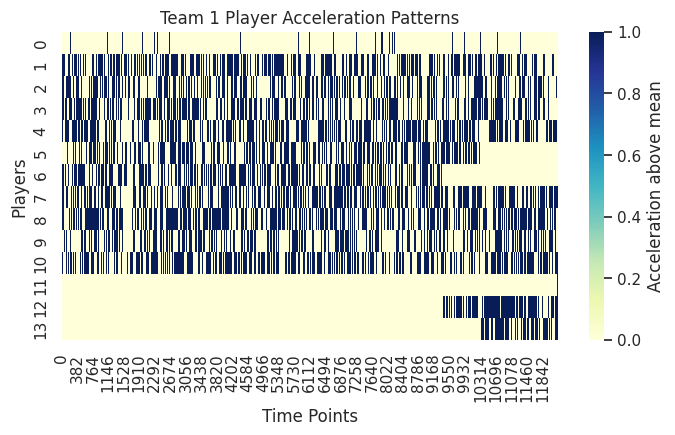

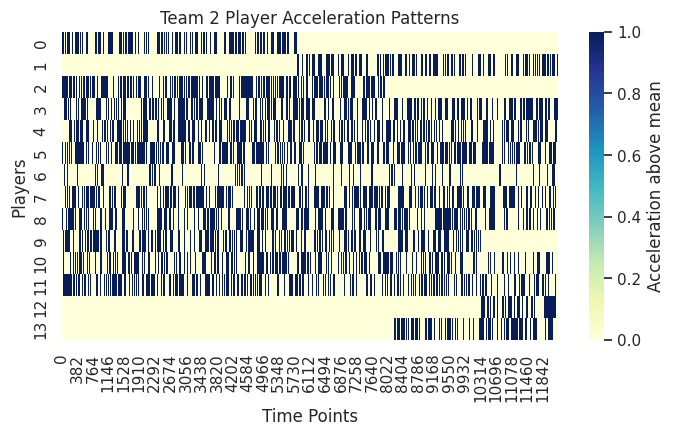

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="white")

# Creating a heatmap for Team 1
plt.figure(figsize=(8, 4))
sns.heatmap(team1_time_series_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Team 1 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

# Creating a heatmap for Team 2
plt.figure(figsize=(8, 4))
sns.heatmap(team2_time_series_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Team 2 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

The goalie and substitutions are clearly visible, but I have not found a good, reliable algorithm yet to tease them out, so let's hand-pick a sub-team for now

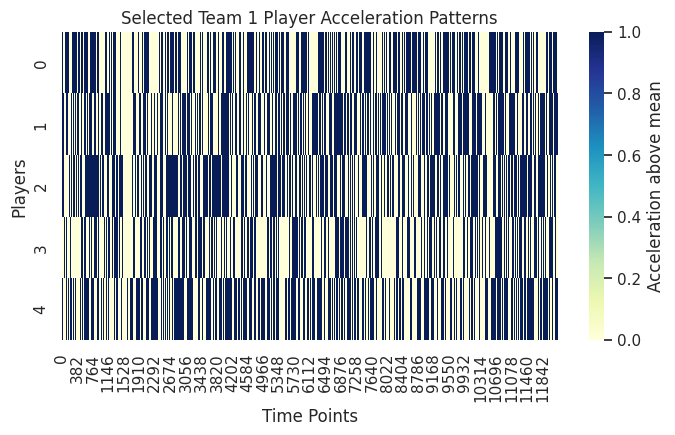

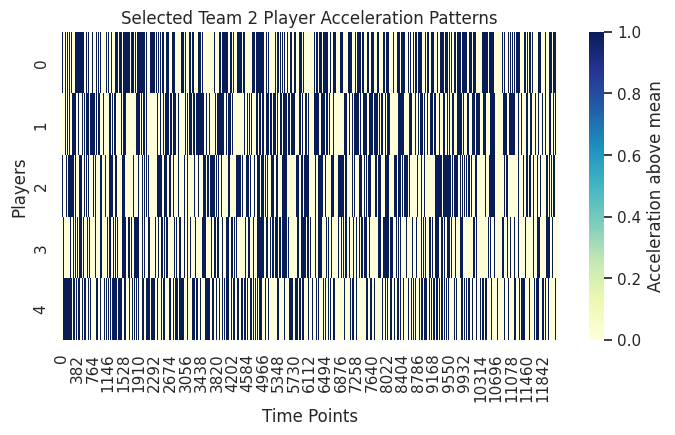

In [3]:
# Sub-selecting players using the new indices for Team 1 and Team 2
team1_new_selected_indices = [4, 7, 8, 9, 10]
team2_new_selected_indices = [5, 7, 8, 10, 11]

# Selecting players based on new indices
team1_selected_players_data = team1_time_series_data[team1_new_selected_indices, :]
team2_selected_players_data = team2_time_series_data[team2_new_selected_indices, :]

# Creating heatmaps for the newly selected players of Team 1 and Team 2
plt.figure(figsize=(8, 4))
sns.heatmap(team1_selected_players_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Selected Team 1 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(team2_selected_players_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Selected Team 2 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

**Compute TPM** *THIS CODE WILL WORK FOR ANY NUMBER OF PLAYERS AND RETURN IN LITTLE ENDIAN*

In [4]:
from itertools import product
import numpy as np

def compute_transition_probability_matrix(time_series_data):
    # Infer the number of states from the data (assuming binary data, the max value + 1)
    num_states = int(np.max(time_series_data) + 1)

    # Number of players
    num_players = time_series_data.shape[0]

    # Total number of possible states (2^num_players)
    total_states = num_states ** num_players

    # Initialize the transition probability matrix with zeros
    TPM = np.zeros((total_states, total_states))

    # Dynamically generate the correct order of states
    all_states = list(product(range(num_states), repeat=num_players))
    correct_order = sorted(all_states, key=lambda x: (sum(x), x[::-1]))
    state_to_index = {state: index for index, state in enumerate(correct_order)}

    # Count the transitions
    for t in range(time_series_data.shape[1] - 1):
        current_state = tuple(time_series_data[:, t])
        next_state = tuple(time_series_data[:, t + 1])
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        TPM[current_index, next_index] += 1

    # Normalize the rows to get probabilities
    for i in range(total_states):
        row_sum = np.sum(TPM[i, :])
        if row_sum > 0:
            TPM[i, :] /= row_sum

    return TPM, correct_order


# Compute the transition probability matrix
TPM1, state_list = compute_transition_probability_matrix(team1_selected_players_data)
TPM2, state_list = compute_transition_probability_matrix(team2_selected_players_data)

take a peek to double check

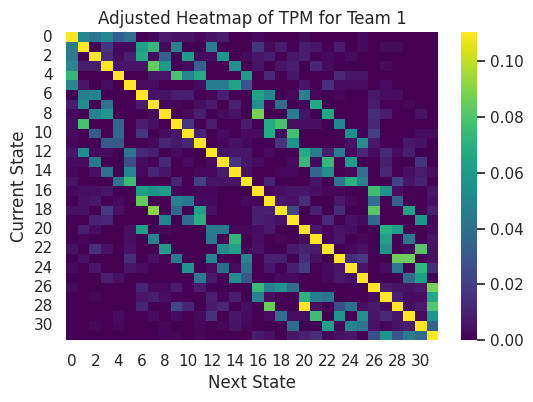

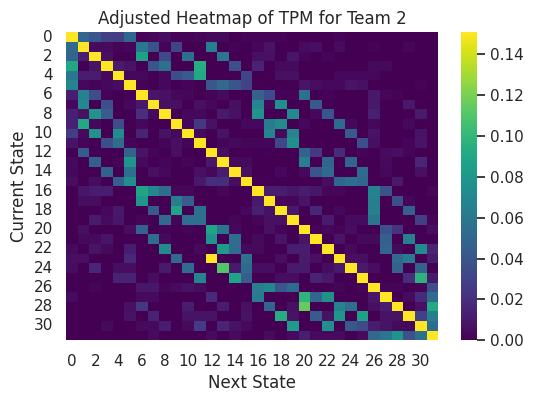

In [5]:
# Function to plot a heatmap with adjusted color scale limits
def plot_adjusted_heatmap(TPM, title, color_limit):
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(TPM, cmap='viridis', vmin=0, vmax=color_limit)
    plt.title(title)
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.show()

# Determining an appropriate color scale limit
# Ignoring the diagonal elements for this calculation
diagonal_ignored_TPM1 = np.copy(TPM1)
diagonal_ignored_TPM2 = np.copy(TPM2)
np.fill_diagonal(diagonal_ignored_TPM1, 0)
np.fill_diagonal(diagonal_ignored_TPM2, 0)

# Find the maximum value in the off-diagonal elements to set as the color limit
color_limit1 = np.max(diagonal_ignored_TPM1)
color_limit2 = np.max(diagonal_ignored_TPM2)

# Plotting adjusted heatmaps for both Team 1 and Team 2
plot_adjusted_heatmap(TPM1, 'Adjusted Heatmap of TPM for Team 1', color_limit1)
plot_adjusted_heatmap(TPM2, 'Adjusted Heatmap of TPM for Team 2', color_limit2)

**Launch PiPhy and compute PHI values**

In [7]:
!pip install -U git+https://github.com/maierav/pyphi
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Check if a result file already exists to save time
if not os.path.exists('alt_team1_phi_results.pkl'):

  # Record the start time
  start_time = time.time()

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C', 'D', 'E')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2, 3, 4)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 5), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)

            sia = pyphi.compute.sia(candidate_system)

            #pyphi.compute.phi(candidate_system)

            '''
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state
            '''

      return phi_values,  #phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  team1_phi_results = calculate_phi_for_tpm(TPM1, possible_states, labels)

  # Saving the results and the list of skipped trials
  with open('alt_team1_phi_results.pkl', 'wb') as file:
    pickle.dump(team1_phi_results, file)

  # Record the end time and calculate duration
  end_time = time.time()
  elapsed_time = end_time - start_time
  # Convert elapsed time into hours, minutes, and seconds
  hours = int(elapsed_time // 3600)
  minutes = int((elapsed_time % 3600) // 60)
  seconds = elapsed_time % 60

  elapsed_time_formatted = f"{hours} hours, {minutes} minutes, {seconds:.2f} seconds"

  print(f"Elapsed time for PHI computation: {elapsed_time_formatted}")

else:
    print("File 'alt_team1_phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/maierav/pyphi to /tmp/pip-req-build-k86ce3rh
  Running command git clone --filter=blob:none --quiet https://github.com/maierav/pyphi /tmp/pip-req-build-k86ce3rh
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 73, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 491, in collect_root_requi